In [43]:
print("hello world")

hello world


In [44]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu, threshold_sauvola


In [45]:
dataset_path = "kaggle_3m"


In [46]:
images = []
masks = []

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(".tif") and "_mask" not in file:
            img_path = os.path.join(root, file)
            mask_path = os.path.join(root, file.replace(".tif", "_mask.tif"))

            if os.path.exists(mask_path):
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

                images.append(img)
                masks.append(mask)

print(len(images))


3929


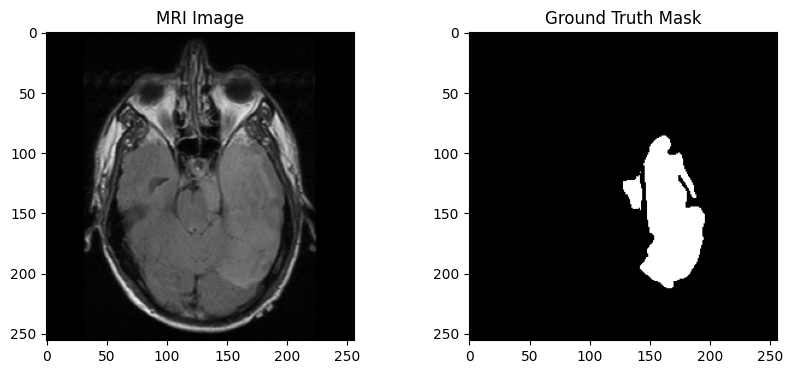

In [47]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(images[100], cmap='gray')
plt.title("MRI Image")

plt.subplot(1,2,2)
plt.imshow(masks[100], cmap='gray')
plt.title("Ground Truth Mask")

plt.show()


In [48]:
def otsu_segmentation(image):
    thresh = threshold_otsu(image)
    return (image > thresh).astype(np.uint8)


In [49]:
def sauvola_segmentation(image):
    thresh = threshold_sauvola(image, window_size=15, k=0.2)
    return (image > thresh).astype(np.uint8)


In [50]:
def dice_score(pred, mask):
    pred = pred.flatten()
    mask = (mask > 0).astype(np.uint8).flatten()
    
    intersection = np.sum(pred * mask)
    return (2 * intersection) / (np.sum(pred) + np.sum(mask) + 1e-8)


In [51]:
def jaccard_index(pred, mask):
    pred = pred.flatten()
    mask = (mask > 0).astype(np.uint8).flatten()
    
    intersection = np.sum(pred * mask)
    union = np.sum(pred) + np.sum(mask) - intersection
    
    return intersection / (union + 1e-8)


In [52]:
#For 1 image
img = images[100]
mask = masks[100]

# Normalize
img = img / 255.0
mask = mask / 255.0
mask = mask.astype(np.uint8)

# Blur for Otsu
img_blur = cv2.GaussianBlur(img, (5,5), 0)

# Thresholding
otsu_pred = otsu_segmentation(img_blur)
sauvola_pred = sauvola_segmentation(img)

# ---- Apply morphology to BOTH predictions ----
kernel = np.ones((3,3), np.uint8)

otsu_pred = cv2.morphologyEx(otsu_pred, cv2.MORPH_OPEN, kernel)
otsu_pred = cv2.morphologyEx(otsu_pred, cv2.MORPH_CLOSE, kernel)

sauvola_pred = cv2.morphologyEx(sauvola_pred, cv2.MORPH_OPEN, kernel)
sauvola_pred = cv2.morphologyEx(sauvola_pred, cv2.MORPH_CLOSE, kernel)

# Ensure binary
otsu_pred = otsu_pred.astype(np.uint8)
sauvola_pred = sauvola_pred.astype(np.uint8)

# Metrics
print("Otsu Dice:", dice_score(otsu_pred, mask))
print("Sauvola Dice:", dice_score(sauvola_pred, mask))

print("Otsu Jaccard:", jaccard_index(otsu_pred, mask))
print("Sauvola Jaccard:", jaccard_index(sauvola_pred, mask))

print("Tumor pixels:", np.sum(mask))


Otsu Dice: 0.31298757826353063
Sauvola Dice: 0.26092537813242705
Otsu Jaccard: 0.18552772595554895
Sauvola Jaccard: 0.15003690747451778
Tumor pixels: 4681


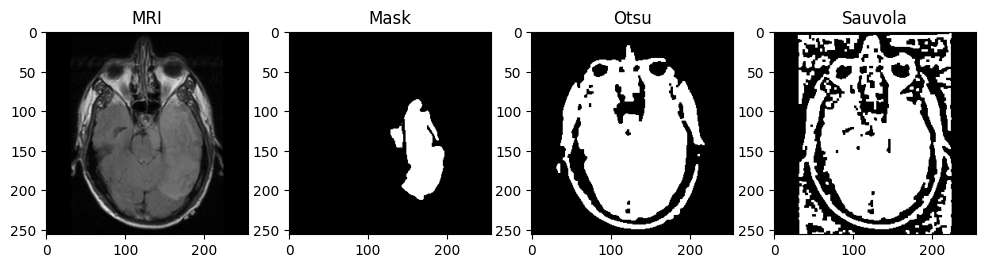

In [53]:
plt.figure(figsize=(12,6))

plt.subplot(1,4,1)
plt.imshow(img, cmap='gray')
plt.title("MRI")

plt.subplot(1,4,2)
plt.imshow(mask, cmap='gray')
plt.title("Mask")

plt.subplot(1,4,3)
plt.imshow(otsu_pred, cmap='gray')
plt.title("Otsu")

plt.subplot(1,4,4)
plt.imshow(sauvola_pred, cmap='gray')
plt.title("Sauvola")

plt.show()


In [54]:
#skipping empty slices - next idea

otsu_dice_list = []
sauvola_dice_list = []

otsu_j_list = []
sauvola_j_list = []

kernel = np.ones((3,3), np.uint8)

valid_slices = 0
empty_slices = 0

for img, mask in zip(images, masks):   # full dataset
    
    # --- Skip empty masks ---
    if np.sum(mask) == 0:
        empty_slices += 1
        continue

    valid_slices += 1

    # --- Normalize ---
    img = img / 255.0
    mask = mask / 255.0
    mask = mask.astype(np.uint8)

    # --- Blur (for Otsu) ---
    img_blur = cv2.GaussianBlur(img, (5,5), 0)

    # --- Thresholding ---
    otsu_pred = otsu_segmentation(img_blur)
    sauvola_pred = sauvola_segmentation(img)

    # --- Morphology ---
    otsu_pred = cv2.morphologyEx(otsu_pred, cv2.MORPH_OPEN, kernel)
    otsu_pred = cv2.morphologyEx(otsu_pred, cv2.MORPH_CLOSE, kernel)

    sauvola_pred = cv2.morphologyEx(sauvola_pred, cv2.MORPH_OPEN, kernel)
    sauvola_pred = cv2.morphologyEx(sauvola_pred, cv2.MORPH_CLOSE, kernel)

    # --- Ensure Binary ---
    otsu_pred = otsu_pred.astype(np.uint8)
    sauvola_pred = sauvola_pred.astype(np.uint8)

    # --- Store Metrics ---
    otsu_dice_list.append(dice_score(otsu_pred, mask))
    sauvola_dice_list.append(dice_score(sauvola_pred, mask))

    otsu_j_list.append(jaccard_index(otsu_pred, mask))
    sauvola_j_list.append(jaccard_index(sauvola_pred, mask))


print("Empty slices skipped:", empty_slices)
print("Valid tumor slices:", valid_slices)

print("Average Otsu Dice:", np.mean(otsu_dice_list))
print("Average Sauvola Dice:", np.mean(sauvola_dice_list))

print("Average Otsu Jaccard:", np.mean(otsu_j_list))
print("Average Sauvola Jaccard:", np.mean(sauvola_j_list))


Empty slices skipped: 2556
Valid tumor slices: 1373
Average Otsu Dice: 0.1450748682438126
Average Sauvola Dice: 0.08558964839879771
Average Otsu Jaccard: 0.08147706657238343
Average Sauvola Jaccard: 0.04596598795565094


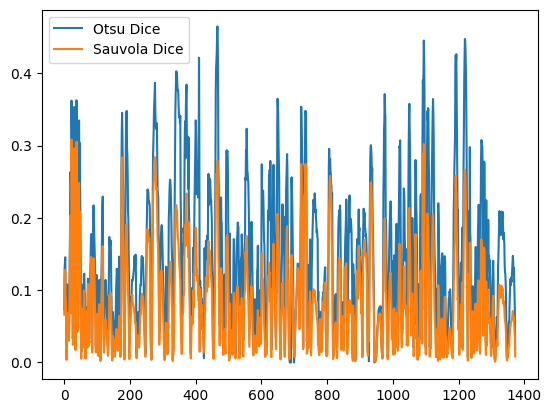

In [55]:
plt.plot(otsu_dice_list, label="Otsu Dice")
plt.plot(sauvola_dice_list, label="Sauvola Dice")
plt.legend()
plt.show()


In [56]:
empty_count = 0

for img, mask in zip(images, masks):

    if np.sum(mask) == 0:
        empty_count += 1

print("Number of empty masks:", empty_count)


Number of empty masks: 2556
